# Learning Tree-augmented Naive Bayes (TAN) Structure from Data

In this notebook, we show an example for learning the structure of a Bayesian Network using the TAN algorithm.  We will first build a model to generate some data and then attempt to learn the model's graph structure back from the generated data.

For comparison of Naive Bayes and TAN classifier, refer to the blog post [Classification with TAN and Pgmpy](https://loudly-soft.blogspot.com/2020/08/classification-with-tree-augmented.html).

## First, create a Naive Bayes graph

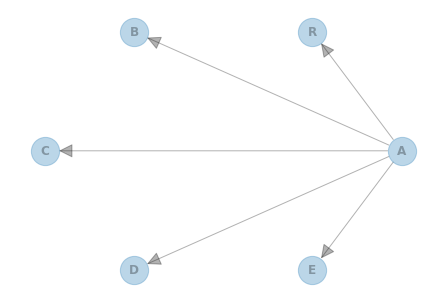

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork

# class variable is A and feature variables are B, C, D, E and R
model = BayesianNetwork([("A", "R"), ("A", "B"), ("A", "C"), ("A", "D"), ("A", "E")])
nx.draw_circular(
    model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

## Second, add interaction between the features

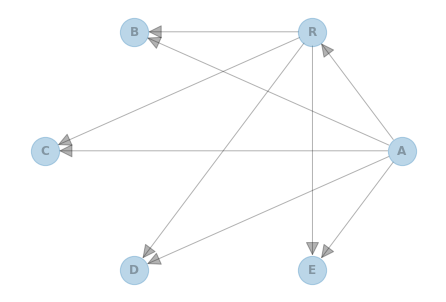

In [3]:
# feature R correlates with other features
model.add_edges_from([("R", "B"), ("R", "C"), ("R", "D"), ("R", "E")])
nx.draw_circular(
    model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

## Then, parameterize our graph to create a Bayesian network

In [4]:
from pgmpy.factors.discrete import TabularCPD

# add CPD to each edge
cpd_a = TabularCPD("A", 2, [[0.7], [0.3]])
cpd_r = TabularCPD(
    "R", 3, [[0.6, 0.2], [0.3, 0.5], [0.1, 0.3]], evidence=["A"], evidence_card=[2]
)
cpd_b = TabularCPD(
    "B",
    3,
    [
        [0.1, 0.1, 0.2, 0.2, 0.7, 0.1],
        [0.1, 0.3, 0.1, 0.2, 0.1, 0.2],
        [0.8, 0.6, 0.7, 0.6, 0.2, 0.7],
    ],
    evidence=["A", "R"],
    evidence_card=[2, 3],
)
cpd_c = TabularCPD(
    "C",
    2,
    [[0.7, 0.2, 0.2, 0.5, 0.1, 0.3], [0.3, 0.8, 0.8, 0.5, 0.9, 0.7]],
    evidence=["A", "R"],
    evidence_card=[2, 3],
)
cpd_d = TabularCPD(
    "D",
    3,
    [
        [0.3, 0.8, 0.2, 0.8, 0.4, 0.7],
        [0.4, 0.1, 0.4, 0.1, 0.1, 0.1],
        [0.3, 0.1, 0.4, 0.1, 0.5, 0.2],
    ],
    evidence=["A", "R"],
    evidence_card=[2, 3],
)
cpd_e = TabularCPD(
    "E",
    2,
    [[0.5, 0.6, 0.6, 0.5, 0.5, 0.4], [0.5, 0.4, 0.4, 0.5, 0.5, 0.6]],
    evidence=["A", "R"],
    evidence_card=[2, 3],
)
model.add_cpds(cpd_a, cpd_r, cpd_b, cpd_c, cpd_d, cpd_e)

## Next, generate sample data from our Bayesian network

In [6]:
from pgmpy.sampling import BayesianModelSampling

# sample data from BN
inference = BayesianModelSampling(model)
df_data = inference.forward_sample(size=10000)
print(df_data)

Generating for node: B: 100%|██████████| 6/6 [00:00<00:00, 192.64it/s]

      A  R  B  C  D  E
0     0  1  2  1  0  0
1     1  2  2  1  2  0
2     0  0  2  0  2  1
3     1  2  2  1  0  1
4     1  2  2  1  0  1
...  .. .. .. .. .. ..
9995  0  0  2  0  1  1
9996  1  2  1  0  0  1
9997  0  0  2  0  1  0
9998  1  0  2  1  0  1
9999  0  0  2  0  2  1

[10000 rows x 6 columns]


## Now we are ready to learn the TAN structure from sample data

Building tree: 100%|██████████| 15/15.0 [00:00<00:00, 5215.93it/s]


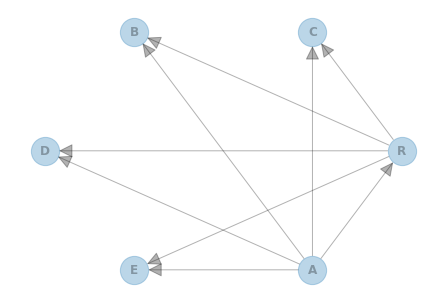

In [7]:
from pgmpy.estimators import TreeSearch

# learn graph structure
est = TreeSearch(df_data, root_node="R")
dag = est.estimate(estimator_type="tan", class_node="A")
nx.draw_circular(
    dag, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

## To parameterize the learned graph from data, check out the other tutorials for more info

In [9]:
from pgmpy.estimators import BayesianEstimator

# there are many choices of parametrization, here is one example
model = BayesianNetwork(dag.edges())
model.fit(
    df_data, estimator=BayesianEstimator, prior_type="dirichlet", pseudo_counts=0.1
)
model.get_cpds()

[<TabularCPD representing P(R:3 | A:2) at 0x7f43c56f1820>,
 <TabularCPD representing P(C:2 | A:2, R:3) at 0x7f43c57328e0>,
 <TabularCPD representing P(B:3 | A:2, R:3) at 0x7f43c56be4c0>,
 <TabularCPD representing P(D:3 | A:2, R:3) at 0x7f43c56f1b20>,
 <TabularCPD representing P(E:2 | A:2, R:3) at 0x7f43c56becd0>,
 <TabularCPD representing P(A:2) at 0x7f43c56f1a00>]